Needed:

- data_helper.py
- dataset/filtered_houses_stats.pkl
- block_ids_alt.tsv

Install on Colab:

- einops
- umap-learn
- fuzzywuzzy
- loguru
- pytorch_lightning

In [ ]:
# !wget https://raw.githubusercontent.com/chaosarium/3D-GANCA/master/data_helper.py
# !wget https://raw.githubusercontent.com/chaosarium/3D-GANCA/master/block_ids_alt.tsv
# !wget https://github.com/chaosarium/3D-GANCA/raw/master/dataset/filtered_houses_stats.pkl4 -P dataset/

In [1]:
# enable pytorch tpu spport
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
# !pip install torch==1.9 torchtext==0.10

In [ ]:
# !mkdir output
# !mkdir output/block2vec

In [ ]:
# !pip install loguru fuzzywuzzy umap-learn==0.5.1 einops pytorch_lightning

In [1]:
import os.path as osp 
import os
import requests
import tarfile

def download():
    data_dir = 'dataset'
    url = "https://craftassist.s3-us-west-2.amazonaws.com/pubr/house_data.tar.gz"
    os.makedirs(data_dir, exist_ok=True)

    tar_path = osp.join(data_dir, "houses.tar.gz")
    if not osp.isfile(tar_path):
        print(f"Downloading dataset from {url}")
        response = requests.get(url, allow_redirects=True)
        if response.status_code != 200:
            raise RuntimeError(
                f"Failed to retrieve image from url: {url}. "
                f"Status: {response.status_code}"
            )
        with open(tar_path, "wb") as f:
            f.write(response.content)

    extracted_dir = osp.join(data_dir, "house_data")
    if not osp.isdir(extracted_dir):
        print(f"Extracting dataset to {extracted_dir}")
        tar = tarfile.open(tar_path, "r")
        tar.extractall(data_dir)

# download()

In [2]:
import os
import sys
import math
import pickle

import numpy as np
import pandas as pd
from typing import Dict, Tuple, List
import importlib
import data_helper
# importlib.reload(data_helper)
from einops import rearrange
from collections import defaultdict
from itertools import product
from tqdm.notebook import tqdm
import umap.umap_ as umap
from pathlib import Path
from fuzzywuzzy import process

from matplotlib.axes import Axes
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import proj3d, Axes3D
from matplotlib import offsetbox
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

from loguru import logger
logger.remove()
logger.add(sys.stdout, colorize=True, format="<blue>{time}</blue> <level>{message}</level>")
logger.level("INFO", color="<red><bold>")

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import init
# from torchviz import make_dot
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
if torch.cuda.is_available():
    print('CUDNN VERSION:', torch.backends.cudnn.version())
    print('Number CUDA Devices:', torch.cuda.device_count())
    print('CUDA Device Name:',torch.cuda.get_device_name(0))
    print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

In [4]:
class ImageAnnotations3D:
    def __init__(self, xyz, imgs: List[np.ndarray], labels: List[str], ax3d: Axes3D, figure: Figure):
        self.xyz = xyz
        self.imgs = imgs
        self.labels = labels
        self.ax3d = ax3d
        self.figure = figure
        self.annot = []
        for xyz, im, label in zip(self.xyz, self.imgs, self.labels):
            x, y = self.proj(xyz)
            self.annot.append(self.image(im, [x, y]))
            self.annot.append(self.label(label, [x, y]))
        self.lim = self.ax3d.get_w_lims()
        self.rot = self.ax3d.get_proj()
        self.cid = self.ax3d.figure.canvas.mpl_connect(
            "draw_event", self.update)

        self.funcmap = {"button_press_event": self.ax3d._button_press,
                        "motion_notify_event": self.ax3d._on_move,
                        "button_release_event": self.ax3d._button_release}

        self.cfs = [self.ax3d.figure.canvas.mpl_connect(kind, self.cb)
                    for kind in self.funcmap.keys()]

    def cb(self, event):
        event.inaxes = self.ax3d
        self.funcmap[event.name](event)

    def proj(self, X):
        """ From a 3D point in axes ax1, 
            calculate position in 2D in ax2 """
        x, y, z = X
        x2, y2, _ = proj3d.proj_transform(x, y, z, self.ax3d.get_proj())
        return x2, y2

    def image(self, arr, xy):
        """ Place an image (arr) as annotation at position xy """
        im = offsetbox.OffsetImage(arr)
        ab = offsetbox.AnnotationBbox(im, xy, pad=0)
        self.ax3d.add_artist(ab)
        return ab

    def label(self, label, xy):
        text = offsetbox.TextArea(label) # minimumdescent=False
        ab = offsetbox.AnnotationBbox(text, xy,
                                      xybox=(0, 16),
                                      xycoords='data',
                                      boxcoords="offset points")
        self.ax3d.add_artist(ab)
        return ab

    def update(self, event):
        if np.any(self.ax3d.get_w_lims() != self.lim) or \
                np.any(self.ax3d.get_proj() != self.rot):
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            for s, ab in zip(self.xyz, self.annot):
                ab.xy = self.proj(s)


In [5]:
class SkipGramModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.target_embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.output = nn.Linear(embedding_dim, num_embeddings)

        initrange = 1.0 / self.embedding_dim
        init.uniform_(self.target_embeddings.weight.data, -
                      initrange, initrange)

    def forward(self, target, context):
        emb_target = self.target_embeddings(target)
        # print('current embedding: ', testskipgrammodel.target_embeddings.weight)

        score = self.output(emb_target)
        # print('score: ', score)
        score = F.log_softmax(score, dim=-1)
        # print('softmax score: ', score)

        losses = torch.stack([F.nll_loss(score, context_word)
                              for context_word in context.transpose(0, 1)])
        return losses.mean()

In [6]:
class Block2VecDatasetV2(Dataset):
    # updated dataset with preprocessing to get rid of unwanted air
    def __init__(self, neighbor_radius = 1, block_ids_table_path='block_ids_alt.tsv', preprocess = True, save_preprocessed = True, load_preprocessed = False):
        super().__init__()
        self.neighbor_radius = neighbor_radius
        self.block_ids_table_path = block_ids_table_path
        
        self._gen_block_id_lookup_dict()
        
        if preprocess == load_preprocessed == False:
            print('hey plz either preprocess or load preprocessed')
            raise
        
        if load_preprocessed:
            logger.info(f"Loading preprocessed block2vec dataset from file")
            try:
                self.preprocessed_dataset = np.load('dataset/block2vec_preprocessed.npy', allow_pickle=True)
                with open("output/block2vec/block2idx.pkl", 'rb') as f:
                    self.block2idx = pickle.load(f)
                with open("output/block2vec/idx2block.pkl", 'rb') as f:
                    self.idx2block = pickle.load(f)
                with open("output/block2vec/block_frequency.pkl", 'rb') as f:
                    self.block_frequency = pickle.load(f)
                logger.info(f"Data loaded")
            except:
                print("fail to load. files don't exist?")
                raise
            
        if preprocess:
            logger.info(f"Preprocessing block2vec dataset")
            self._read_blocks()
            self._preprpcess()
        
        if save_preprocessed:
            logger.info(f"Saving preprocessed block2vec dataset to file")
            np.save('dataset/block2vec_preprocessed.npy', self.preprocessed_dataset)
            logger.info("Saving idx2block and block2idx")
            with open(os.path.join("output/block2vec/block2idx.pkl"), "wb") as f:
                pickle.dump(self.block2idx, f)
            with open(os.path.join("output/block2vec/idx2block.pkl"), "wb") as f:
                pickle.dump(self.idx2block, f)
            with open(os.path.join("output/block2vec/block_frequency.pkl"), "wb") as f:
                pickle.dump(self.block_frequency, f)

        padding = 2 * self.neighbor_radius  # one token on each side

    # generate size limits for reading self.world with given neighbor radius
    def _read_size(self, neighbor_radius=1):
        return [neighbor_radius, self.world.shape[0] - neighbor_radius - 1], [neighbor_radius, self.world.shape[1] - neighbor_radius - 1], [neighbor_radius, self.world.shape[2] - neighbor_radius - 1]
    
    # generate dictionary for converting block id to names
    def _gen_block_id_lookup_dict(self):
        mc_block_database = pd.read_csv('block_ids_alt.tsv', sep='\t')
        mc_block_database = mc_block_database.filter(items=['numerical id', 'item id'])
        mc_block_database = mc_block_database.dropna(subset=["numerical id"])
        mc_block_database
        self.block_id_lookup_dict = mc_block_database.set_index('numerical id').to_dict()['item id']
    
    # loop through and register all blocks to get block2idx and idx2block i.e. create vocabulary
    def _read_blocks(self):
        self.world = data_helper.all_trainx_as_df()# [:3] # only take first 100 for now
        self.world = self.world['world']
        self.world = np.stack(self.world, axis=0)
        self.world = rearrange(self.world, 'n x y z b -> (n x) y z b')
        self.world = self.world[:,:,:,0]
        logger.info(f"Loaded in world with shape: {self.world.shape}")
        
        self.x_lims, self.y_lims, self.z_lims = self._read_size(neighbor_radius=0)
        
        self.block_frequency = defaultdict(int)
        coordinates_to_track = self._gen_coords(*(self._read_size(neighbor_radius=0)))
        logger.info("Collecting {} blocks for frequency calculation", len(coordinates_to_track))
        for coords in tqdm(coordinates_to_track):
            numerical_id = self._get_block(coords[0], coords[1], coords[2])
            # treating all meta of same id the same for simplicity
                
            item_id = self.block_id_lookup_dict[str(numerical_id)]
                
            self.block_frequency[item_id] += 1

        logger.info(f"Found {len(self.block_frequency)} unique blocks")
        
        self.block2idx = dict()
        self.idx2block = dict()
        for name, count in self.block_frequency.items():
            block_idx = len(self.block2idx)
            self.block2idx[name] = block_idx
            self.idx2block[block_idx] = name
        logger.info("idx2block and block2idx dictionaries generated")
        
    # return the block id at x y z coords
    def _get_block(self, x, y, z):
        # returns the id for the block
        return self.world[x][y][z]

    # return a list of block ids of neighboring blocks
    def _get_neighbors(self, x, y, z, neighbor_radius=1):
        neighbor_coords = [(x + x_diff, y + y_diff, z + z_diff) for x_diff, y_diff, z_diff in product(list(range(-neighbor_radius, neighbor_radius + 1)), repeat=3) if x_diff != 0 or y_diff != 0 or z_diff != 0]
        return [self._get_block(*coord) for coord in neighbor_coords]

    # generate the full list of coords within limits
    def _gen_coords(self, x_lims, y_lims, z_lims):
        return [(x, y, z) for x, y, z in product(range(x_lims[0], x_lims[1] + 1), range(y_lims[0], y_lims[1] + 1), range(z_lims[0], z_lims[1] + 1))]
        
    # make target context pairs while ignoring all air places
    def _preprpcess(self):
        air_removed = 0
        preprocessed_dataset = [] # list of [target, contex]
        
        x_lims, y_lims, z_lims = self._read_size(neighbor_radius=self.neighbor_radius)
        coordinates_to_preprocess = self._gen_coords(*(self._read_size(neighbor_radius=self.neighbor_radius)))
        logger.info("Preprocessing {} blocks for target context pairs creation", len(coordinates_to_preprocess))
        
        for coords in tqdm(coordinates_to_preprocess):
            numerical_id = self._get_block(coords[0], coords[1], coords[2])
            neighbors_numerical_ids = self._get_neighbors(*coords)
            
            if numerical_id == 0 and neighbors_numerical_ids == [0]*len(neighbors_numerical_ids):
                # remove and log if too much air
                air_removed += 1
            else:
                # if not airy add to dataset
                item_id = self.block_id_lookup_dict[str(numerical_id)]
                target = self.block2idx[item_id]
                # target = torch.tensor(int(target))
                
                neighbors_item_ids = [self.block_id_lookup_dict[str(numerical_id)] for numerical_id in neighbors_numerical_ids]
                context = [self.block2idx[item_id] for item_id in neighbors_item_ids]
                # context = torch.tensor(context)
                
                preprocessed_dataset.append((target, context))
        
        # turn into np array
        self.preprocessed_dataset = np.array(preprocessed_dataset)
                
        logger.info(f"Removed {air_removed} examples that are too airy.")
        logger.info(f"Generated {self.__len__()} example data preprocessed dataset.")
        
    def __len__(self):
        return len(self.preprocessed_dataset)
    
    def __getitem__(self, index):
        target, context = self.preprocessed_dataset[index]
        return torch.tensor(target), torch.tensor(context)

In [7]:
class Block2Vec(pl.LightningModule):
    def __init__(self, embedding_dim = 32, initial_lr = 1e-3, neighbor_radius = 1, batch_size = 256, num_epochs = 30, preprocess = True, save_preprocessed = True, load_preprocessed = False):
        super().__init__()
        self.save_hyperparameters() # making lightning save params under self.hparams
        
        self.dataset = Block2VecDatasetV2(neighbor_radius=neighbor_radius, preprocess=preprocess, save_preprocessed=save_preprocessed, load_preprocessed=load_preprocessed)
        
        self.embedding_dim = embedding_dim
        self.learning_rate = initial_lr # initial learning rate
        self.neighbor_radius = neighbor_radius
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.output_path = "output/block2vec"

        self.num_embeddings = len(self.dataset.block2idx)
        self.model = SkipGramModel(self.num_embeddings, self.embedding_dim)
        self.textures = dict()
        
        # print(self.model)
        
    def forward(self, target, context) -> torch.Tensor:
        return self.model(target, context)

    def training_step(self, batch):
        loss = self.forward(*batch)
        self.log("loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            math.ceil(len(self.dataset) / self.batch_size) *
            self.num_epochs,
        )
        return [optimizer], [scheduler]
    
    def train_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
        )
        
    def on_epoch_end(self):
        embedding_dict = self.save_embedding(self.dataset.idx2block, self.output_path)
        embedding_dict = self.save_embedding(
            self.dataset.idx2block, self.output_path
        )
        self.create_confusion_matrix(
            self.dataset.idx2block, self.output_path)
        # self.plot_embeddings(embedding_dict, self.output_path)

    def read_texture(self, block: str):
        if block not in self.textures and block != "air":
            texture_candidates = Path(
                "/home/schubert/projects/TOAD-GAN/minecraft/block2vec/textures"
            ).glob("*.png")
            # use of absolute path is intentional
            match = process.extractOne(block, texture_candidates)
            if match is not None:
                logger.info("Matches {} with {} texture file", block, match[0])
                self.textures[block] = plt.imread(match[0])
        if block not in self.textures:
            self.textures[block] = np.ones(shape=[16, 16, 3])
        return self.textures[block]

    def save_embedding(self, id2block: Dict[int, str], output_path: str):
        embeddings = self.model.target_embeddings.weight
        # embeddings = embeddings / torch.norm(embeddings, p=2, dim=-1, keepdim=True)
        embeddings = embeddings.cpu().data.numpy()
        embedding_dict = {}
        with open(os.path.join(output_path, "embeddings.txt"), "w") as f:
            f.write("%d %d\n" % (len(id2block), self.embedding_dim))
            for wid, w in id2block.items():
                e = " ".join(map(lambda x: str(x), embeddings[wid]))
                embedding_dict[w] = torch.from_numpy(embeddings[wid])
                f.write("%s %s\n" % (w, e))
        np.save(os.path.join(output_path, "embeddings.npy"), embeddings)
        with open(os.path.join(output_path, f"representations.pkl"), "wb") as f:
            pickle.dump(embedding_dict, f)
        return embedding_dict
    
    def plot_embeddings(self, embedding_dict: Dict[str, np.ndarray], output_path: str):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        legend = [label.replace("minecraft:", "")
                  for label in embedding_dict.keys()]
        texture_imgs = [self.read_texture(block) for block in legend]
        embeddings = torch.stack(list(embedding_dict.values())).numpy()
        if embeddings.shape[-1] != 3:
            embeddings_3d = umap.UMAP(
                n_neighbors=5, min_dist=0.3, n_components=3
            ).fit_transform(embeddings)
        else:
            embeddings_3d = embeddings
        for embedding in embeddings_3d:
            ax.scatter(*embedding, alpha=0)
        ia = ImageAnnotations3D(embeddings_3d, texture_imgs, legend, ax, fig)
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "scatter_3d.png"), dpi=300)
        plt.close("all")

    def create_confusion_matrix(self, id2block: Dict[int, str], output_path: str):
        rcParams.update({"font.size": 6})
        names = []
        dists = np.zeros((len(id2block), len(id2block)))
        for i, b1 in id2block.items():
            names.append(b1.split(":")[1])
            for j, b2 in id2block.items():
                dists[i, j] = F.mse_loss(
                    self.model.target_embeddings.weight.data[i],
                    self.model.target_embeddings.weight.data[j],
                )
        confusion_display = ConfusionMatrixDisplay(dists, display_labels=names)
        confusion_display.plot(include_values=False,
                               xticks_rotation="vertical")
        confusion_display.ax_.set_xlabel("")
        confusion_display.ax_.set_ylabel("")
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "dist_matrix.png"))
        plt.close()

In [42]:
NUM_EPOCHS = 16

block2vec = Block2Vec(embedding_dim = 64, initial_lr = 1e-3, neighbor_radius = 1, batch_size = 256, num_epochs = NUM_EPOCHS, preprocess = False, save_preprocessed = False, load_preprocessed = True)

2022-02-15T13:30:12.093984+0800 Loading preprocessed block2vec dataset from file
2022-02-15T13:30:23.637951+0800 Data loaded


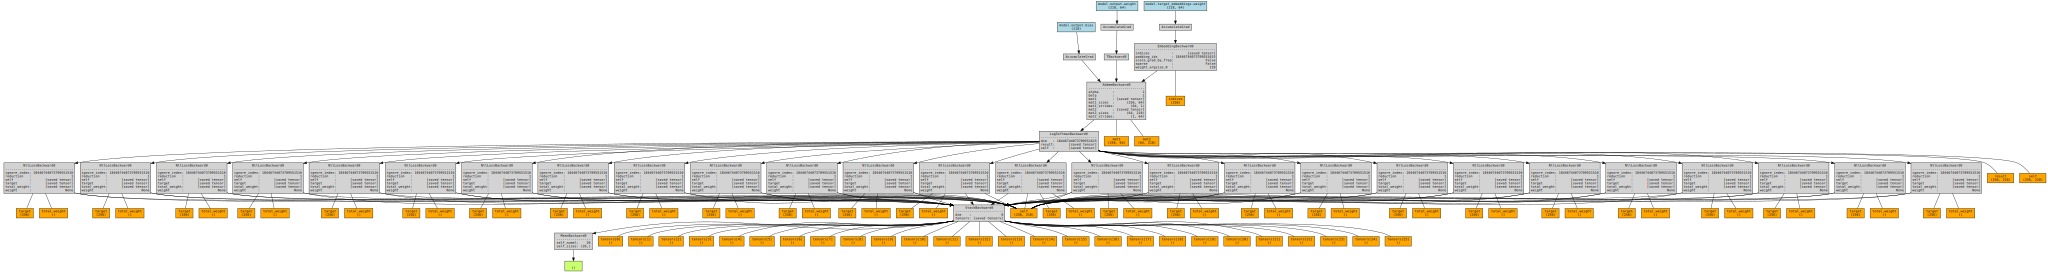

In [43]:
# see the graph
from torchviz import make_dot

y = block2vec.forward(torch.randint(0,217,(256,)), torch.randint(0,217,(256,26)))
# make_dot(y.mean(), params=dict(sample_generator.named_parameters()))
make_dot(y, params=dict(block2vec.named_parameters()), show_attrs=True, show_saved=True, max_attr_chars=100)

In [ ]:
trainer = pl.Trainer(gpus=0, max_epochs=NUM_EPOCHS, fast_dev_run=False)
trainer.fit(block2vec)